In [134]:
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import ann
import csv
from typing import Any, Tuple
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import os

## Разделяем датасет на train test val

In [206]:
splitfolders.ratio('dataset', 'data_set_for_lerning',ratio=(0.8, 0.1, 0.1), seed=13, group_prefix=None)

Copying files: 2200 files [00:03, 605.82 files/s]


## Создание аннотаций 

In [207]:
def create_annotation(subdir:str,label, folderpath, name_csv) -> None:
    with open(f"annotation_{name_csv}.csv", mode="a", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
        for i in range(2200):
            absolute_way = os.path.abspath(f'{folderpath}/{name_csv}/{subdir}/{i}.jpg')
            if (os.path.isfile(absolute_way)) == True:
                file_writer.writerow([absolute_way,label])

In [208]:
folderpath='data_set_for_lerning'
with open("annotation_train.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"train")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"train")

folderpath='data_set_for_lerning'
with open("annotation_test.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"test")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"test")

folderpath='data_set_for_lerning'
with open("annotation_val.csv", mode="a", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=";", lineterminator='\n')
    file_writer.writerow(["folder_path", "label"])
subdir = "CatIT"
create_annotation(subdir,1,folderpath,"val")
subdir = "DogIT"
create_annotation(subdir,0,folderpath,"val")

## Сверточная нейросеть Создание собственного набора данных

In [209]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, target_transform: Any=None) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.dataset_info = pd.read_csv(path_to_annotation_file, delimiter=';')
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset_info.iloc[index, 0]
    image = cv2.cvtColor(cv2.imread(path_to_image), cv2.COLOR_BGR2RGB)
    label = self.dataset_info.iloc[index, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_Transform(label)
      
    return image, label

In [210]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        
        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)
        
        self.fc_1 = nn.Linear(576, 10) # 43264 - пока что определяем экспериментальным путем (:
        self.fc_2 = nn.Linear(10, 1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        # print(torch.nn.Flatten()(output).shape) - определить можно, распечатав вот это

        output = torch.nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = torch.nn.Sigmoid()(self.fc_2(output))
        return output

In [211]:
device = torch.device(
    "cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = CNN().to(device)
torch.cuda.is_available()

False

In [142]:
device

device(type='cpu')

In [212]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = CustomImageDataset( 'annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## loop 1

In [213]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 15
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum() # 4
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()

        epoch_val_accuracy += acc / len(val_dataset)
        epoch_val_loss += loss / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)


    
    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.5721590909090915, train loss : 0.169814333319664
Epoch : 1, val accuracy : 0.6454545454545452, val loss : 0.15503855049610138
Epoch : 2, train accuracy : 0.6340909090909098, train loss : 0.16206616163253784
Epoch : 2, val accuracy : 0.7045454545454545, val loss : 0.2524847090244293
Epoch : 3, train accuracy : 0.7113636363636378, train loss : 0.14441683888435364
Epoch : 3, val accuracy : 0.7727272727272728, val loss : 0.14414890110492706
Epoch : 4, train accuracy : 0.7596590909090926, train loss : 0.12233653664588928
Epoch : 4, val accuracy : 0.7818181818181819, val loss : 0.17822638154029846
Epoch : 5, train accuracy : 0.8096590909090937, train loss : 0.10595163702964783
Epoch : 5, val accuracy : 0.790909090909091, val loss : 0.4266415238380432
Epoch : 6, train accuracy : 0.8414772727272756, train loss : 0.09105705469846725
Epoch : 6, val accuracy : 0.7772727272727273, val loss : 0.06876978278160095
Epoch : 7, train accuracy : 0.8744318181818219, train los

### графики

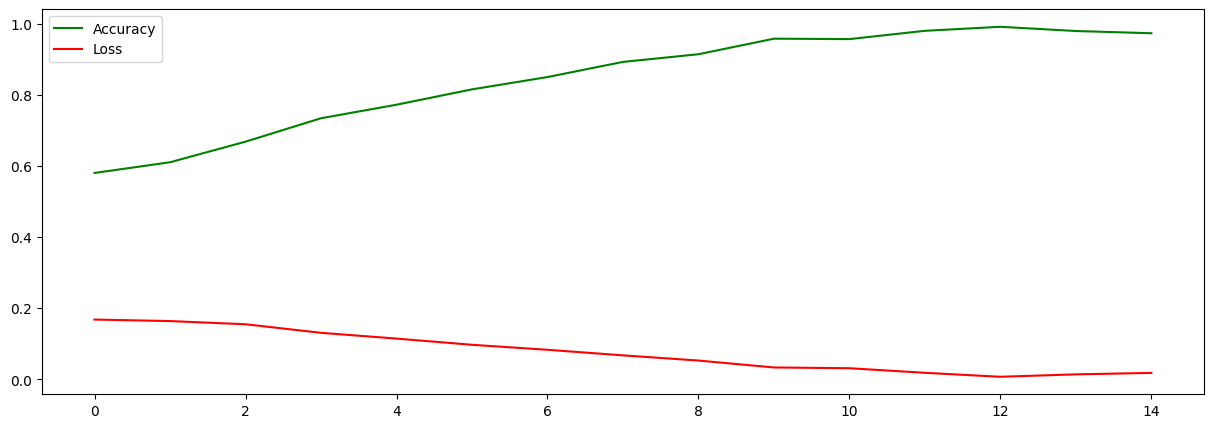

In [145]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="red")
plt.legend(["Accuracy", "Loss"])

### Тестовые данные 

In [146]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
    test_accuracy += acc / len(test_dataset)
    test_loss += float(loss.detach()) / len(test_dataset)
f"test_accuracy={ test_accuracy} test_loss={test_loss}"

'test_accuracy=0.7636363636363637 test_loss=0.005838759709149601'

## Loop 2 

In [162]:
custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset = CustomImageDataset( 'annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
optimizer = optim.Adam(params=model.parameters(), lr=0.005)

In [163]:

criterion = nn.BCELoss()
epochs = 9
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum() # 4
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()

        epoch_val_accuracy += acc / len(val_dataset)
        epoch_val_loss += loss / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)


    
    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.9187500000000044, train loss : 0.05008910223841667
Epoch : 1, val accuracy : 0.7590909090909093, val loss : 0.04116450250148773
Epoch : 2, train accuracy : 0.9380681818181867, train loss : 0.047437697649002075
Epoch : 2, val accuracy : 0.7499999999999996, val loss : 0.04835125803947449
Epoch : 3, train accuracy : 0.9261363636363681, train loss : 0.047892987728118896
Epoch : 3, val accuracy : 0.7636363636363636, val loss : 0.015506826341152191
Epoch : 4, train accuracy : 0.9193181818181861, train loss : 0.05322100594639778
Epoch : 4, val accuracy : 0.7500000000000002, val loss : 0.00046915392158553004
Epoch : 5, train accuracy : 0.9227272727272765, train loss : 0.049134474247694016
Epoch : 5, val accuracy : 0.790909090909091, val loss : 0.002828780096024275
Epoch : 6, train accuracy : 0.949431818181824, train loss : 0.03927193209528923
Epoch : 6, val accuracy : 0.7681818181818179, val loss : 0.011956809088587761
Epoch : 7, train accuracy : 0.940909090909096

### График

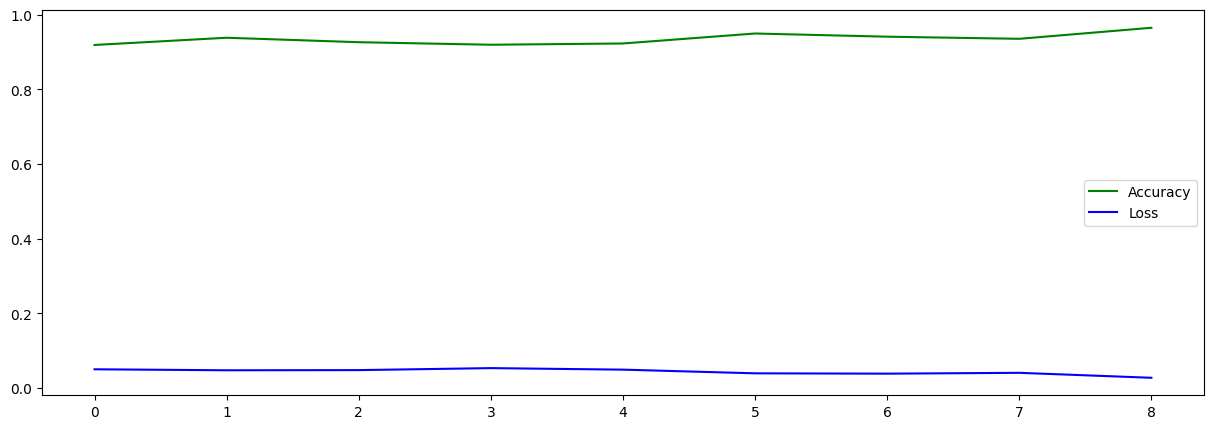

In [164]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

### На тестовых данных

In [165]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
    test_accuracy += acc / len(test_dataset)
    test_loss += float(loss.detach()) / len(test_dataset)
f"test_accuracy={ test_accuracy} test_loss={test_loss}"

'test_accuracy=0.7681818181818182 test_loss=0.00014958449173718677'

## Loop 3

In [194]:
train_dataset = CustomImageDataset('annotation_train.csv', custom_transforms)
test_dataset = CustomImageDataset('annotation_test.csv', custom_transforms)
val_dataset = CustomImageDataset('annotation_val.csv', custom_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False)
optimizer = optim.Adam(params=model.parameters(), lr=0.01)

In [195]:

criterion = nn.BCELoss()
epochs = 9
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum() # 4
        epoch_accuracy += acc / len(train_dataset)
        epoch_loss += loss / len(train_dataset)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()

        epoch_val_accuracy += acc / len(val_dataset)
        epoch_val_loss += loss / len(val_dataset)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)


    
    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

Epoch : 1, train accuracy : 0.714204545454545, train loss : 0.13993313908576965
Epoch : 1, val accuracy : 0.5090909090909091, val loss : 0.16606028378009796
Epoch : 2, train accuracy : 0.5903409090909094, train loss : 0.16599614918231964
Epoch : 2, val accuracy : 0.5000000000000001, val loss : 0.14213497936725616
Epoch : 3, train accuracy : 0.49545454545454626, train loss : 0.17373372614383698
Epoch : 3, val accuracy : 0.5000000000000001, val loss : 0.17330749332904816
Epoch : 4, train accuracy : 0.5181818181818191, train loss : 0.1732902079820633
Epoch : 4, val accuracy : 0.5000000000000001, val loss : 0.16876564919948578
Epoch : 5, train accuracy : 0.49090909090909146, train loss : 0.17364175617694855
Epoch : 5, val accuracy : 0.5000000000000001, val loss : 0.17363859713077545
Epoch : 6, train accuracy : 0.4965909090909098, train loss : 0.1734648048877716
Epoch : 6, val accuracy : 0.5000000000000001, val loss : 0.17029711604118347
Epoch : 7, train accuracy : 0.4750000000000002, train

### График

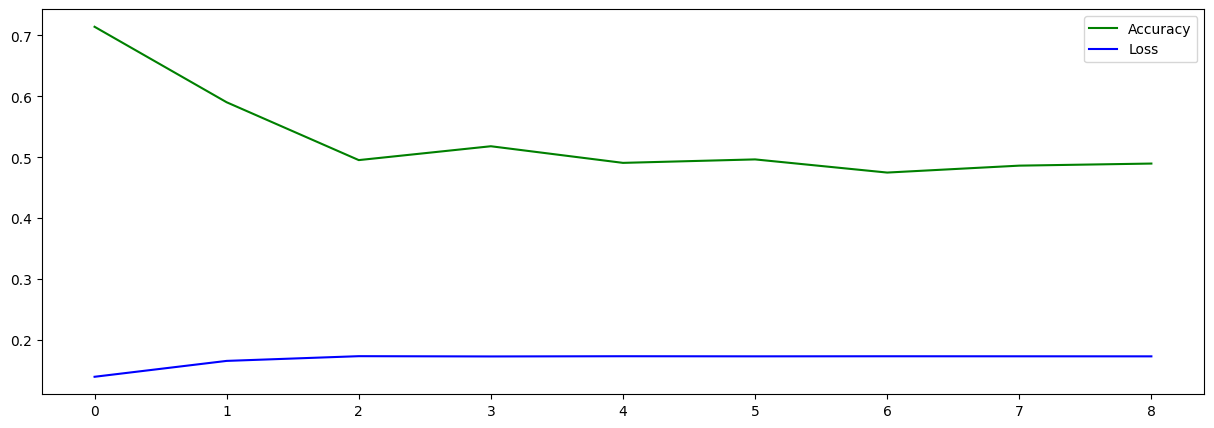

In [196]:
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.plot(range(len(accuracy_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Accuracy", "Loss"])

### На тестовых данных

In [197]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
    test_accuracy += acc / len(test_dataset)
    test_loss += float(loss.detach()) / len(test_dataset)
f"test_accuracy={ test_accuracy} test_loss={test_loss}"

'test_accuracy=0.5000000000000001 test_loss=0.17454199492931352'

## Сохранение Модели

In [214]:
torch.save(model.state_dict(), os.path.join("dataset", "weight2.pt"))

## Загрузка модели

In [215]:
model = CNN()
model.load_state_dict(torch.load(os.path.join("dataset", "weight2.pt")))

<All keys matched successfully>

## Проверка модели на тестовых данных

In [217]:
model.eval()

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data.to(device)
    label = label.to(device)

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(4)])).sum()
    test_accuracy += acc / len(test_dataset)
    test_loss += float(loss.detach()) / len(test_dataset)

    
test_accuracy, test_loss

(0.7590909090909091, 1.1895471288880807e-05)

## Пользуемся !

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


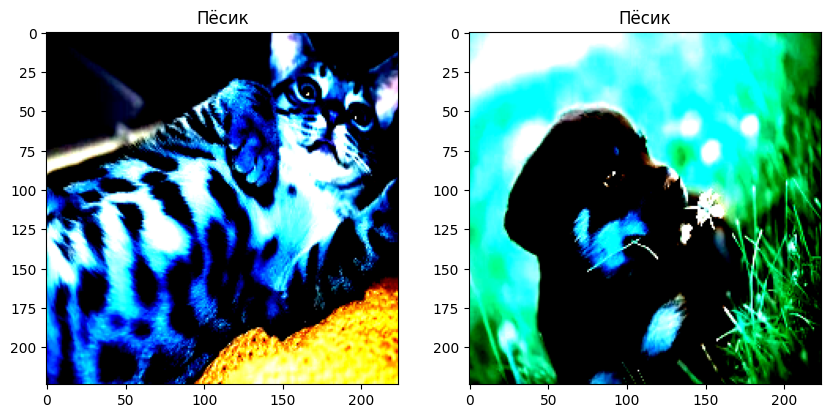

In [245]:
import random
plt.figure(figsize=(10, 5))

for j in range(2):
  index = random.randint(0, 210)
  plt.subplot(1, 2, j + 1)
  plt.title("Пёсик" if (1 if  model(test_dataset[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "Котик")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy()[:, :, ::-1])